In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

In [3]:
X = pd.read_csv('X_data.csv', sep=';', index_col=[0], skiprows=range(1,4267))

In [ ]:
X.head()

In [4]:
trainY = pd.read_csv('Y_train.csv', sep=';', header=None, index_col=[0], names=["Time", "Quality"])

In [5]:
testY = pd.read_csv('Y_submit.csv', sep=';', header=None, index_col=[0], names=["Time", "Quality"])

In [6]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [7]:
test_size = 0.15

In [8]:
#Добавим признаков на основе времени и значений качества
Y = pd.concat([trainY, testY])
data = pd.DataFrame(Y.copy())
data.columns = ["Quality"]
test_index = int(len(trainY)*(1-test_size))

data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data["month"] = data.index.month
data['is_weekend'] = data.weekday.isin([5,6])*1

data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "Quality").get, data.weekday))
data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "Quality").get, data.hour))
data["month_average"] = list(map(code_mean(data[:test_index], 'month', "Quality").get, data.month))

data.drop(["hour", "weekday", "month"], axis=1, inplace=True)

data

,Quality,is_weekend,weekday_average,hour_average,month_average
Time,,,,,
2015-01-04 00:05:00,392,1,400.373029,403.595745,402.850000
2015-01-04 01:05:00,384,1,400.373029,403.321083,402.850000
2015-01-04 02:05:00,393,1,400.373029,403.178917,402.850000
2015-01-04 03:05:00,399,1,400.373029,402.901354,402.850000
2015-01-04 04:05:00,400,1,400.373029,402.333656,402.850000
...,...,...,...,...,...
2018-12-31 19:05:00,420,0,406.200450,403.588577,393.827285
2018-12-31 20:05:00,420,0,406.200450,403.883833,393.827285
2018-12-31 21:05:00,420,0,406.200450,404.576960,393.827285


In [9]:
df = pd.DataFrame()
df

""


In [10]:
n = X.shape[0]
i = 0
while(n > 60):
  begin = 60*i
  end = 60*(i+1)
  df = df.append(X[begin:end].mean(), ignore_index=True)
  i = i + 1
  n = n - 60

In [11]:
df.loc[:, 'weekday_avg'] = data['weekday_average'].values
df.loc[:, 'month_avg'] = data['month_average'].values
df.loc[:, 'hour_avg'] = data['hour_average'].values
df.loc[:, 'weekend'] = data['is_weekend'].values

In [29]:
"""
def lags(lag_start, lag_end):
  for i in range(lag_start, lag_end):
    data["lag_{}".format(i)] = data.Quality.shift(i)
    df.loc[:, "lag_{}".format(i)] = data["lag_{}".format(i)].values
    
lags(lag_start=12, lag_end=18)    
df = df.dropna()
df = df.reset_index(drop=True)
"""

In [12]:
size_train = trainY.shape[0]

In [13]:
train_X = df[:size_train]

In [14]:
size_test = testY.shape[0]
test_X = df[size_train:(size_train + size_test)]

In [ ]:
X_tr = train_X.loc[:test_index]
y_tr = trainY['Quality'][:test_index + 1]
X_val = train_X.loc[test_index+1:]
y_val = trainY['Quality'][test_index + 1:]
X_tr

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_squared_error as mse

In [17]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100, random_state=17)
forest.fit(X_tr, y_tr)
forest_valid_pred = forest.predict(X_val)
r2_score(y_val, forest_valid_pred)

0.931584891503667

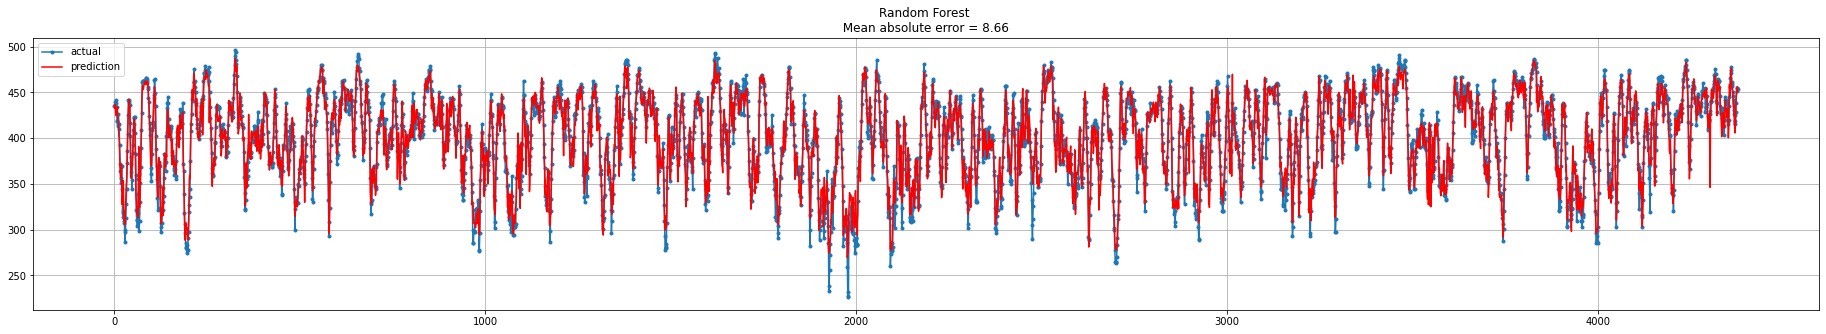

In [18]:
plt.figure(figsize=(32, 5))
plt.plot(y_val.values, marker='.', label="actual")
plt.plot(forest_valid_pred, "r", label="prediction")
plt.legend(loc="best")
plt.title("Random Forest \n Mean absolute error = {} ".format(round(mae(forest_valid_pred, y_val), 2)))
plt.grid(True);

MAE = 8.66 единиц качества на валидационной выборке.

In [19]:
forest_valid_pred

array([436.24, 432.41, 436.86, ..., 455.68, 456.18, 451.04])

In [20]:
y_val

Time
2017-11-02 15:05:00    435
2017-11-02 16:05:00    435
2017-11-02 17:05:00    435
2017-11-02 18:05:00    440
2017-11-02 19:05:00    442
                      ... 
2018-05-03 19:05:00    438
2018-05-03 20:05:00    452
2018-05-03 21:05:00    455
2018-05-03 22:05:00    455
2018-05-03 23:05:00    454
Name: Quality, Length: 4377, dtype: int64

In [21]:
testY['Quality'] = forest.predict(test_X)

In [22]:
testY['Quality'].to_csv('Y_submit.csv', header=False)